In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
# DEEP Q-LEARNING NETWORK CLASS

# DQN is a derived class of the nn.Module class
class DQN(nn.Module):
    
    # derived class constructor
    def __init__(self, img_height, img_width): 
        
        # base class constructor
        super().__init__()

        # define the layers of weights and biases
        # nn.Linear means fully connected layers
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    # feed forward method
    # t is a tensor, an image is a tensor of rank 2
    def forward(self, t):
        
        # reduce the tensor rank from 2 to 1
        t = t.flatten(start_dim=1)
        
        # use ReLu from torch.nn.functional as activation function for layer 1 and layer 2
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        
        # output layer without activation function
        t = self.out(t)
        
        return t

In [4]:
# EXPERIENCE CLASS

Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward'])

In [5]:
# REPLAY MEMORY CLASS

class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    # method to record a new experience
    def push(self, experience):
        
        # append experience to memory if memory is not full
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
            
        # cyclically overwrite old memories if memory if full
        else:
            self.memory[self.push_count % self.capacity] = experience
            
        # push count used to keep track of where the cycle is
        self.push_count += 1
        
    # method to sample a random batch of experience from the experience pool
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # method to check if replay memory is big enough to satisfy the requested sample size
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [6]:
# EPSILON GREEDY STRATEGY CLASS

class EpsilonGreedyStrategy():
    
    def __init__(self, start, end, decay):
        
        # starting epsilon value. range from 0 to 1
        self.start = start
        
        # ending epsilon value, should be smaller than starting epsilon value
        self.end = end
        
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
# AGENT CLASS

class Agent():
    
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        
        # strategy = EpsilonGreedyStrategy()
        self.strategy = strategy
        
        # num_actions is the total number of actions that the agent can make
        self.num_actions = num_actions
        
        # computing device
        self.device = device
    
    # policy_net is an instance of class DQN
    # state is a representation of the input image
    def select_action(self, state, policy_net):
        
        # get exploration rate according to current step
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        # explore
        if rate > random.random():
            action = random.randrange(self.num_actions)
            
            # pass action as a tensor to the device (GPU)
            return torch.tensor([action]).to(self.device)
        
        # exploit
        else:
            
            # turn off gradient since there is no training involved in an inference
            with torch.no_grad():
                
                # argmax(dim=1) returns the index of the highest value in the input tensor, and reduces the rank by 1
                # policy_net(state) calls the forward method in the DQN class, as a built in feature
                return policy_net(state).argmax(dim=1).to(self.device)

In [8]:
# ENVIRONMENT CLASS

class CartPoleEnvManager():
    
    def __init__(self, device):
        self.device = device
        
        # unwrapped allows access to behind-the-scene dynamics
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    # reset encapsulation
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    # close encapsulation
    def close(self):
        self.env.close()
    
    # render encapsulation
    def render(self, mode='human'):
        return self.env.render(mode)
    
    # get total number of available actions
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        
        # underscore ignores values
        # item() returns value as standard python number
        _, reward, self.done, _ = self.env.step(action.item())
        
        # pass reward as a tensor to the device (GPU)
        return torch.tensor([reward], device=self.device)
    
    # check if the game is at initial state
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
    
        # return black screen if game is just starting or has ended
        if self.just_starting() or self.done:
            
            # save current screen for later use, but return black screen instead
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        
        # return the difference between the previous screen and the current screen
        # in order to account for the change between time steps
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
    
        # render returns a 3D matrix of dimensions height, width, channel (R, G, B)
        # transpose changes the matrix axes to channel, height, width
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        
#         # close render window to prevent crash
#         self.close()
        
        return self.transform_screen_data(screen)

    # crop away top and bottom as they are redundant pixels
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        
        # copy the entire first dimension
        # copy only top (0.4) to bottom (0.8) in the second dimension
        # copy the entire third dimension
        screen = screen[:, top:bottom, :]
        return screen
    
    # convert screen data into tensor
    def transform_screen_data(self, screen):
        
        # convert screen data into a contiguous float data array in the memory
        # map the value from 0-255 to 0-1
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        
        # convert screen data into tensor data
        screen = torch.from_numpy(screen)
        
        # use torchvision package to compose image transforms
        # torchvision.transform as T
        resize = T.Compose([
            
            # transform into PIL image to resize
            # PIL: Python Image Library
            T.ToPILImage(),
            T.Resize([40,90]),
            
            # transform back to tensor after resizing
            T.ToTensor()
        ])
        
        # resize screen data
        # unsqueeze adds an extra dimension to the tensor, for tensors are passed in batches
        return resize(screen).unsqueeze(0).to(self.device)

In [9]:
# # NON-PROCESSED SCREEN EXAMPLE

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # environment manager
# em = CartPoleEnvManager(device)
# em.reset
# screen = em.render('rgb_array')

# plt.figure()
# plt.imshow(screen)
# plt.title('Non-processed screen example')
# plt.show

In [10]:
# # PROCESSED SCREEN EXAMPLE

# screen = em.get_processed_screen()

# plt.figure()

# # move screen data back to cpu to use numpy functions like squeeze
# # squeeze removes dimensions with length 1
# # use permute to move channel dimension back to 3rd dimension
# plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0), interpolation='none')

# plt.title('Processed screen example')
# plt.show

In [11]:
# TRAINING PERFORMANCE PLOTS

# values is the time taken for each episode
# moving average is a statistical average that takes average over a certain period
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    
    # convert to float tensor
    values = torch.tensor(values, dtype=torch.float)
    
    if len(values) >= period:
        
        # check decumentation for unfold unfold
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        
        # concatenate zeros to the front of the moving averages
        # since the first period-1 values cannot provide a moving average
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
        
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [12]:
# TENSOR PROCESSING FUNCTION

def extract_tensors(expriences):
    
    # zip takes in a set of array iterators (eg. experiences[0], experiences[1], ...) and
    # returns an array containing the 0th element of each array, another array containing the 1st element of each array,
    # and another array containing... etc.
    # the * operator unpacks the list into arguments
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

In [13]:
# Q-VALUE CALCULATOR CLASS

class QValues():
    device = torch.device("cuda")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        
        # gather uses actions to select the corresponding state value in the 'states' tensor
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_next, next_states):
        
        # from the next_states tensor, flatten the height dimension (0th dimension is for different next states),
        # then find the max value along the flattened dimension (2nd dimension is now 1st dimension),
        # [0] just takes the value inside the tensor
        # if the value is equal to 0, that state is a black screen state.
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        
        # negate final_state_locations
        non_final_state_locations = (final_state_locations == False)
        
        non_final_states = next_states[non_final_state_locations] 
        
        # shape[0]: length of 0th dimension, meaning how many next_states are available
        batch_size = next_states.shape[0]
        
        #send empty values to device
        values = torch.zeros(batch_size).to(QValues.device)
        
        # infer action values using states, select max action value
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        
        return values

In [14]:
# Notes for tensor

# a = [1, 2, 3, 4]
# b = [1, 0, 0, 1]
# a = torch.tensor(a)
# b = torch.tensor(b).type(torch.bool)
# a[b]

In [15]:
# plot(np.random.rand(300), 100)

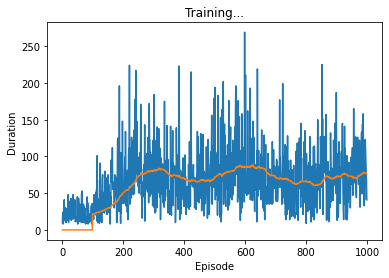

Episode 1000 
 100 episode moving avg: 75.96


In [16]:
# MAIN PROGRAM ==============================================================

# HYPERPARAMETERS ===========================================================

batch_size = 256

# discount factor for discounted return 
gamma = 0.95

# exploration rate
eps_start = 1
eps_end = 0.01
eps_decay = 0.0007

# number of episodes before updating the target network
target_update = 10

# replay memory size
memory_size = 100000

# learning rate
lr = 0.005

num_episodes = 1000

# OBJECT INSTANCES ===========================================================

device = torch.device("cuda")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

# copy weights and biases
target_net.load_state_dict(policy_net.state_dict())

# evaluation mode tells pytorch that this is not for training but only for inference
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

# MAIN LOOP =================================================================

episode_durations = []

# episode loop
for episode in range (num_episodes):
    em.reset()
    state = em.get_state()
    
    # timestep loop
    for timestep in count():
        
        # gaining experience
        action = agent.select_action(state,policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        # learning from experience
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            # get Q value predicted by the policy network from the current state and action
            current_q_values = QValues.get_current(policy_net, states, actions)

            # get the Q value predicted by the target network from the next state
            next_q_values = QValues.get_next(target_net, next_states)

            # Bellman Optimality Equation
            target_q_values = (next_q_values * gamma) + rewards

            # mse is mean squared error
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

            # set gradients of weights and biases to zero
            # to avoid previous gradients from accumulating
            optimizer.zero_grad()

            loss.backward()

            # update the weights and biases based on the loss
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    
    # update target network when episode reaches a multiple of the update period
    if episode % target_update == 0:
        
        # copy the weights and biases of the policy network to the target network
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()